In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("housing.csv")

In [3]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### 入力変数と教師データ

In [4]:
x = df.iloc[:, :-1].values.astype('f')
t = df.iloc[:, -1].values.astype('f')

In [6]:
x.shape

(506, 13)

In [9]:
# 教師データのサイズ => 回帰では 506行１列にする必要がある
t.shape

(506,)

In [11]:
t = t.reshape(len(t), 1)
t.shape

(506, 1)

### データセットの準備

In [16]:
dataset = list(zip(x, t))

### 訓練データと検証データの分割

In [17]:
import chainer
import chainer.functions as F
import chainer.links as L

In [18]:
n_train = int(len(dataset) * 0.7)
n_train

354

In [19]:
train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed=0)

In [20]:
len(train)

354

In [21]:
len(test)

152

### モデルの定義
- classifier 使用する場合

In [117]:
class NN(chainer.Chain):
    
    # モデルの構造
    def __init__(self, n_mid_units=5, n_out=1):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(None, n_out)
            self.bn = L.BatchNormalization(13)
            
    # 順伝播
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [118]:
np.random.seed(0)
# インスタンス化
nn = NN()

In [119]:
# 損失関数は平均二乗誤差を設定
model = L.Classifier(nn, lossfun=F.mean_squared_error)
model.compute_accuracy = False

### モデルの定義
- 自前で書く場合
  - `__init__` : モデルで使用するリンクの宣言
  - `__call__` : 損失関数の宣言
  - `predictor` : 順伝播の宣言

In [120]:
# class NN(chainer.Chain):
    
#     # モデルの構造
#     def __init__(self, n_mid_units=5, n_out=1):
#         super().__init__()
#         with self.init_scope():
#             self.fc1 = L.Linear(None, n_mid_units)
#             self.fc2 = L.Linear(None, n_out)
    
    
#     # 損失関数の計算
#     def __call__(self, x, t):
#         # 予測値の計算（順伝播）
#         y = self.predictor(x)
#         # 損失関数
#         loss = F.mean_squared_error(t, y)
#         # レポート機能
#         chainer.report({'loss': loss}, self)
#         return loss
    
    
#     # 順伝播
#     def __predictor__(self, x):
#         h = self.fc1(x)
#         h = F.relu(h)
#         h = self.fc2(h)
#         return h

In [121]:
# np.random.seed(0)
# model = NN()

In [122]:
optimizer = chainer.optimizers.Adam()

In [123]:
optimizer.setup(model)

In [124]:
batchsize = 10
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [125]:
from chainer import training

In [126]:
updater = training.StandardUpdater(train_iter, optimizer, device = -1)

In [127]:
from chainer.training import extensions

In [128]:
epoch = 500

In [129]:
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/housing')

trainer.extend(extensions.Evaluator(test_iter, model, device=-1))
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

### 学習の実行

In [130]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           575.005     603.083               0.156002      
2           558.217     591.554               0.312785      
3           548.793     574.242               0.461857      
4           521.226     547.619               0.626767      
5           504.153     507.164               0.781187      
6           462.463     468.416               1.00615       
7           408.87      413.969               1.20433       
8           366.207     357.926               1.39418       
9           293.685     257.43                1.5339        
10          241.922     227.014               1.6786        
11          192.413     178.442               1.83908       
12          154.55      143.469               1.9991        
13          118.269     114.239               2.14277       
14          99.1176     100.104               2.28512       
15          85.8354     81.4782               2.44322       
16          70.8336     71

129         26.2957     17.601                20.0268       
130         28.3503     20.4513               20.1699       
131         23.4538     17.0709               20.3166       
132         27.0238     17.4956               20.4605       
133         29.6658     16.2019               20.6509       
134         26.648      16.9675               20.7882       
135         22.3553     17.6617               20.936        
136         27.6813     16.8084               21.078        
137         23.5214     16.664                21.2276       
138         25.1738     17.0243               21.3719       
139         29.423      16.4812               21.5298       
140         26.817      17.3971               21.678        
141         27.0338     17.1789               21.8269       
142         24.1305     16.5635               21.978        
143         26.9474     18.0898               22.1287       
144         29.6502     19.9942               22.2791       
145         21.1949     

258         24.8524     13.682                39.9065       
259         25.1436     13.3753               40.0869       
260         21.4437     14.6462               40.3504       
261         20.0668     14.0585               40.5504       
262         24.1593     14.4965               40.7005       
263         23.8758     14.195                40.8796       
264         22.1086     14.8935               41.0538       
265         19.7763     15.1051               41.228        
266         27.2487     14.2034               41.4105       
267         21.5067     16.9805               41.573        
268         24.7487     13.3826               41.7377       
269         20.6153     15.1596               41.9321       
270         22.9457     13.6819               42.1091       
271         19.064      15.41                 42.2846       
272         21.9487     13.9314               42.4414       
273         19.7314     14.7931               42.6154       
274         22.8678     

387         20.6183     12.8664               60.2368       
388         23.9082     15.6663               60.3858       
389         23.0302     13.4909               60.5356       
390         20.304      13.3771               60.6767       
391         25.5978     12.7709               60.8234       
392         22.8735     13.8702               60.9693       
393         23.6984     13.8294               61.1223       
394         18.7096     13.8391               61.2724       
395         22.9778     13.7048               61.4144       
396         19.8746     13.2688               61.5611       
397         24.2605     14.8249               61.7079       
398         23.5887     14.1132               61.8549       
399         24.7313     14.5143               62.0056       
400         20.575      14.3892               62.1509       
401         20.0783     14.082                62.3025       
402         21.482      14.0207               62.4491       
403         23.3933     

In [131]:
import json

In [132]:
with open('result/housing/log') as f:
    logs = json.load(f)
    results = pd.DataFrame(logs)

In [133]:
results.head()

,elapsed_time,epoch,iteration,main/loss,validation/main/loss
0,0.156002,1,36,575.004989,603.082876
1,0.312785,2,71,558.216524,591.553692
2,0.461857,3,107,548.792547,574.241863
3,0.626767,4,142,521.225994,547.618906
4,0.781187,5,177,504.152722,507.163916


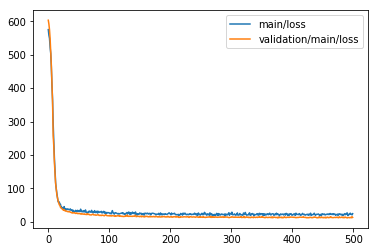

In [134]:
results[['main/loss', 'validation/main/loss']].plot()

In [135]:
loss = results['validation/main/loss'].values[-1]
loss

13.4302117228508

In [136]:
import math

In [137]:
math.sqrt(loss)

3.6647253270676097

In [138]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
